In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Defaults

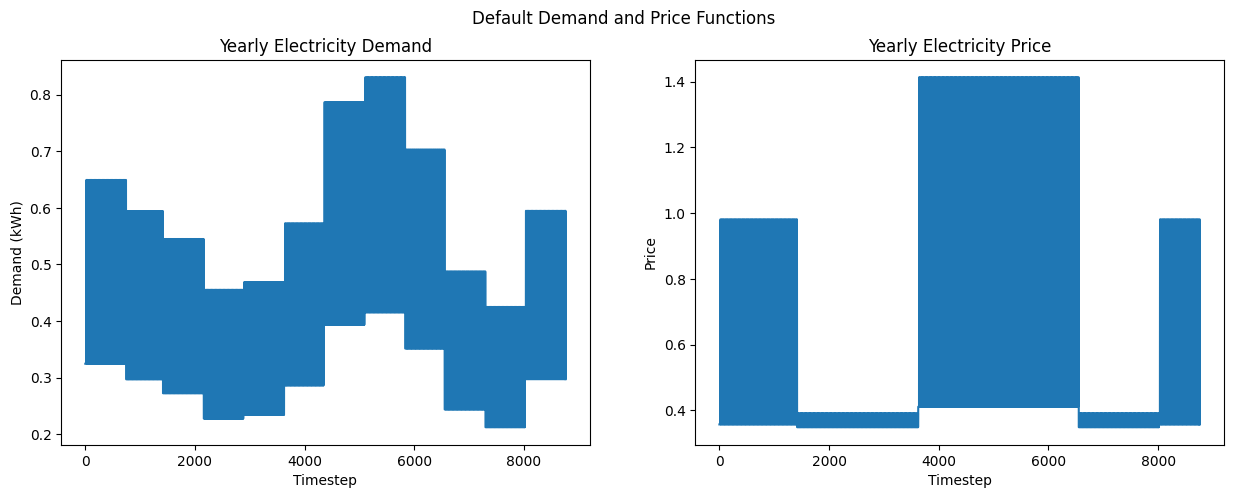

In [15]:
from defaults import _days_in_month, _demand_default_fn, _price_default_fn


demands = [_demand_default_fn(hour, day, month)
           for month in range(1, 13)
           for day in range(1, _days_in_month(month)+1)
           for hour in range(24)
          ]

prices = [_price_default_fn(hour, day, month)
           for month in range(1, 13)
           for day in range(1, _days_in_month(month)+1)
           for hour in range(24)
          ]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(demands)
axes[0].set_title('Yearly Electricity Demand')
axes[0].set_ylabel('Demand (kWh)')
axes[0].set_xlabel('Timestep')

axes[1].plot(prices)
axes[1].set_title('Yearly Electricity Price')
axes[1].set_ylabel('Price')
axes[1].set_xlabel('Timestep')

fig.suptitle("Default Demand and Price Functions")

plt.savefig('images/defaults.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Base Environment

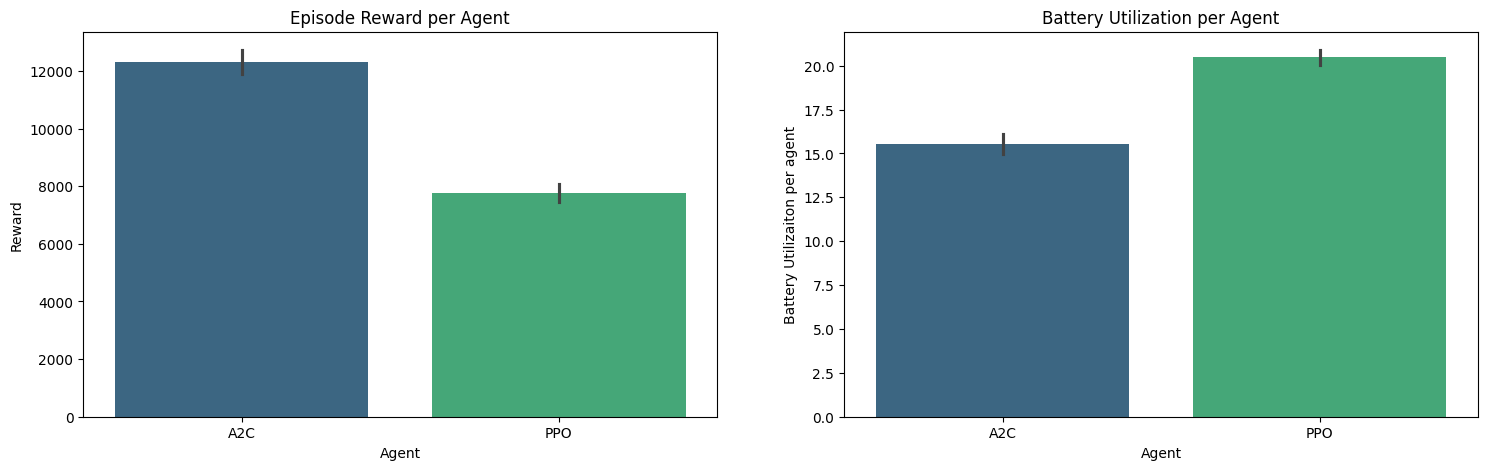

In [14]:
all_data = []

for agent in ["PPO", "A2C"]:
    df = pd.read_csv(f"logs/{agent}/base_env_eval.csv")
    df['agent'] = agent
    all_data.append(df)

all_data = pd.concat(all_data)
all_data['discharge'] = all_data['soc'].diff().clip(upper=0).abs()
all_data.loc[all_data.step == 1, 'discharge'] = 0
all_data['demand_from_battery'] = all_data[['discharge', 'demand']].min(axis=1)
grouped_df = all_data.groupby(['agent', 'episode']).sum().reset_index()
grouped_df['battery_util'] = (grouped_df['demand_from_battery'] / grouped_df['demand'])*100

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.barplot(data=grouped_df, x='agent', y='reward', hue='agent', palette='viridis', errorbar='sd', ax=axes[0])
axes[0].set_xlabel("Agent")
axes[0].set_ylabel("Reward") 
axes[0].set_title("Episode Reward per Agent")

sns.barplot(data=grouped_df, x='agent', y='battery_util', hue='agent', palette='viridis', errorbar='sd', ax=axes[1])
axes[1].set_title("Battery Utilization per Agent")
axes[1].set_xlabel("Agent")
axes[1].set_ylabel("Battery Utilizaiton per agent")

plt.savefig('images/rewards_and_battery_utils.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Market Environment

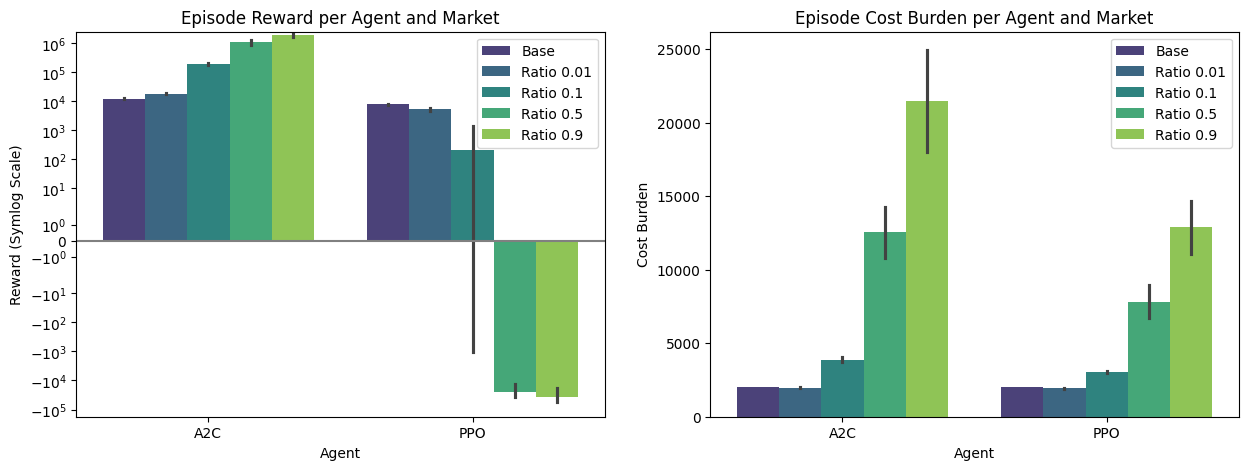

In [13]:
all_data = pd.DataFrame()
for agent in ["PPO", "A2C"]:
    df_base = pd.read_csv(f"logs/{agent}/base_env_eval.csv", index_col=0)
    df_base['agent'] = agent
    df_base['env'] = 'Base'
    all_data = pd.concat([all_data, df_base])
    
    for ratio in ["0.01", "0.1", "0.5", "0.9"]:
        df_ratio = pd.read_csv(f"logs/{agent}/{ratio}/true_market_simulation.csv", index_col=0)
        df_ratio['agent'] = agent
        df_ratio['env'] = f"Ratio {ratio}"
        all_data = pd.concat([all_data, df_ratio])

all_data['cost'] = all_data['price'] * all_data['demand']
grouped_df = all_data.groupby(['agent', 'env', 'episode']).sum().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(data=grouped_df, x='agent', y='reward', hue='env', palette='viridis', errorbar='sd', ax=axes[0])
axes[0].axhline(y=0, color='gray', linestyle='-')
axes[0].set_yscale('symlog')
axes[0].set_xlabel("Agent")
axes[0].set_ylabel("Reward (Symlog Scale)")
axes[0].legend(title='')
axes[0].set_title("Episode Reward per Agent and Market")

sns.barplot(data=grouped_df, x='agent', y='cost', hue='env', palette='viridis', errorbar='sd', ax=axes[1])
axes[1].set_title("Episode Cost Burden per Agent and Market")
axes[1].set_xlabel("Agent")
axes[1].set_ylabel("Cost Burden")
axes[1].legend(title='')

plt.savefig('images/market_simulation.pdf', format='pdf', bbox_inches='tight')
plt.show()